In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# build MultiScaleDeformableAttention
!cd /content/drive/MyDrive/models/dino/ops
!export TORCH_CUDA_ARCH_LIST="7.5;8.0;8.6;8.9"   # 7.5 for grand-challenge's online GPU (T4), 8.6 for 3090
!python /content/drive/MyDrive/models/dino/ops/setup.py install

running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [1]:
!pip install addict

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
!pip install yapf==0.31.0

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 20.6 MB/s eta 0:00:00


In [ ]:
# train dino swin enumeration32 detection
!python /content/drive/MyDrive/train_dino.py \
    --output_dir /content/drive/MyDrive/output_dino_swin_enum32 -c /content/drive/MyDrive/configs/dino/DINO_4scale_swin_cls32.py --coco_path /content/drive/MyDrive/dentex_dataset/coco/enumeration32 \
    --options dn_scalar=100 embed_init_tgt=TRUE \
    dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
    dn_box_noise_scale=1.0 \
    --pretrain_model_path /content/drive/MyDrive/checkpoints/dino_pretrained_checkpoint0029_4scale_swin.pth --finetune_ignore label_enc.weight class_embed

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# transfer dino swin enumeration32 detection to train disease detection
!python /content/drive/MyDrive/train_dino.py \
	--output_dir /content/drive/MyDrive/output_dino_swin_disease -c /content/drive/MyDrive/configs/dino/DINO_4scale_swin_cls4.py --coco_path /content/drive/MyDrive/dentex_dataset/coco/disease \
	--options dn_scalar=100 embed_init_tgt=TRUE \
	dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
	dn_box_noise_scale=1.0 \
	--pretrain_model_path /content/drive/MyDrive/output_dino_swin_enum32/checkpoint0020.pth --finetune_ignore label_enc.weight class_embed

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# continue training on full disease dataset
!python /content/drive/MyDrive/train_dino.py \
	--output_dir /content/drive/MyDrive/output_swin_disease_all -c /content/drive/MyDrive/configs/dino/DINO_4scale_swin_cls4.py --coco_path /content/drive/MyDrive/dentex_dataset/coco/disease_all \
	--options dn_scalar=100 embed_init_tgt=TRUE \
	dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
	dn_box_noise_scale=1.0 \
	--resume /content/drive/MyDrive/output_dino_swin_disease/checkpoint0017.pth

Output hidden; open in https://colab.research.google.com to view.

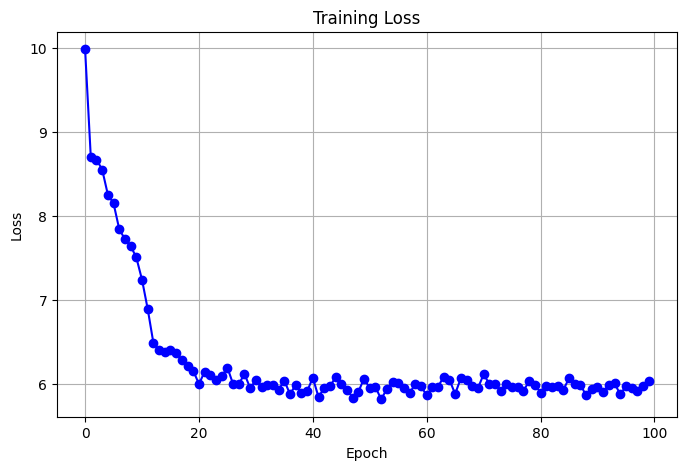

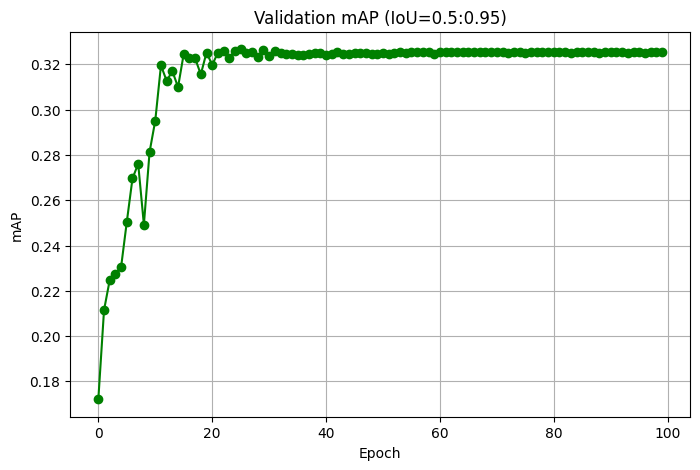

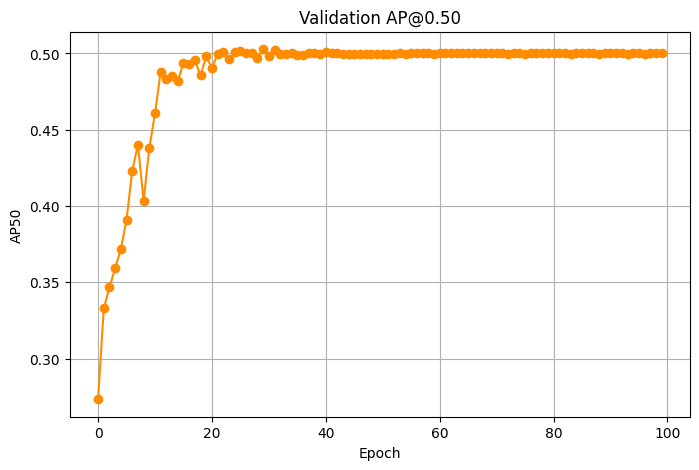

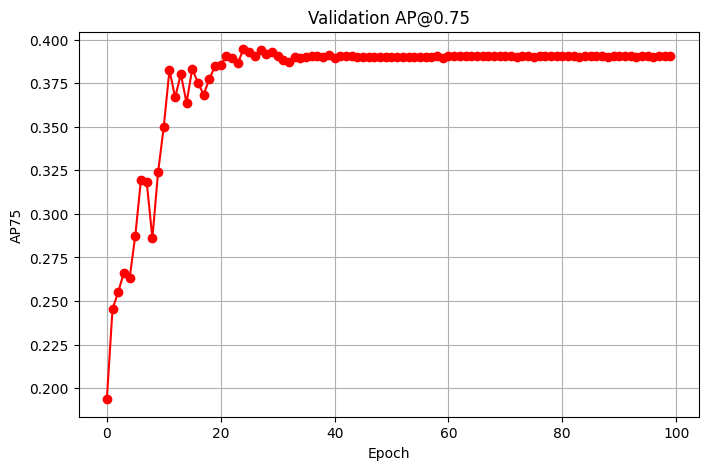

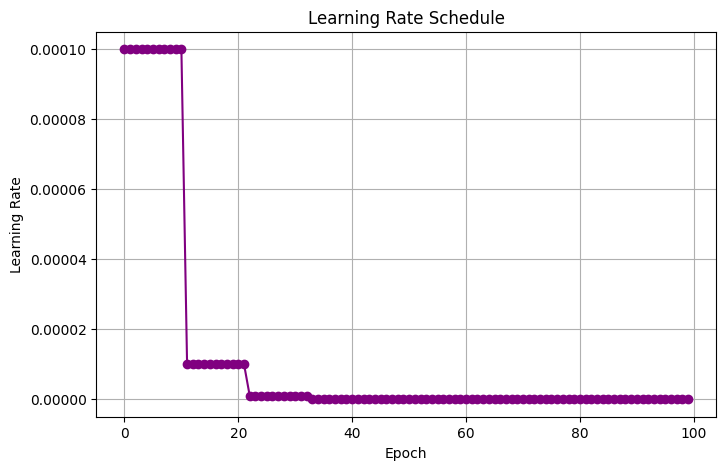

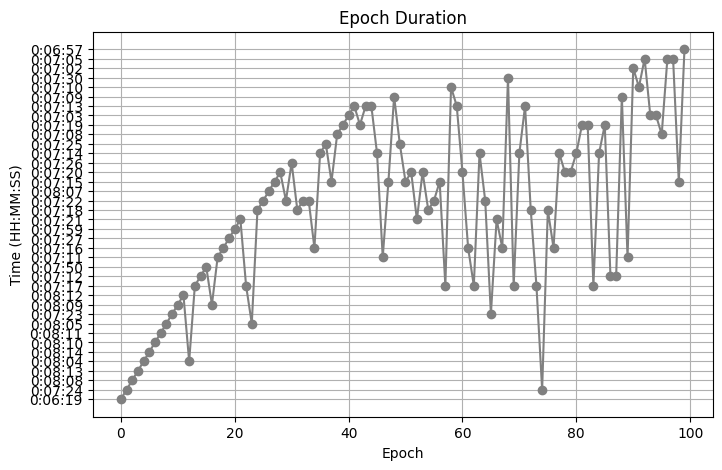

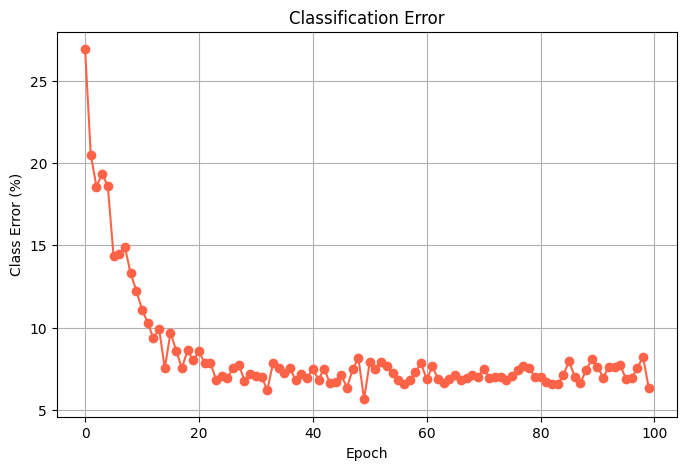

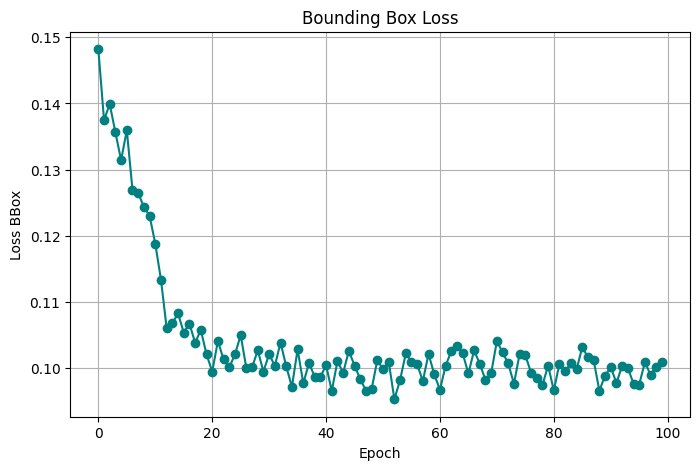

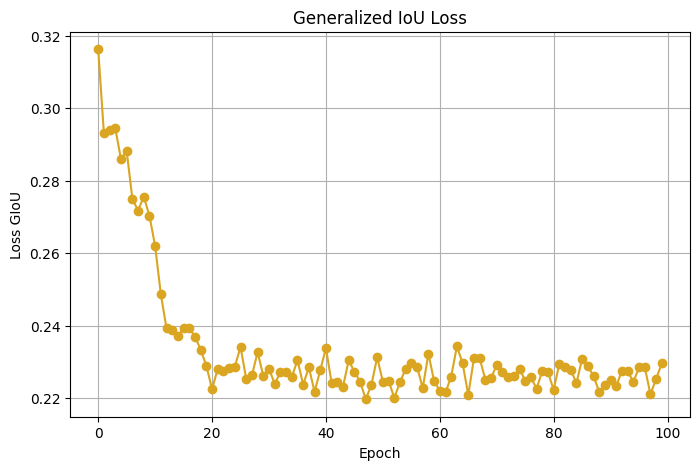

In [3]:
import json
import matplotlib.pyplot as plt
import os
#/content/drive/MyDrive/output_swin_disease_all/log.txt

# ==== Set path to your training log ====
log_path = "/content/drive/MyDrive/output_dino_swin_disease/log.txt"  # <-- Your actual log path

# ==== Read and Parse Log ====
logs = []
with open(log_path, "r") as f:
    for line in f:
        try:
            logs.append(json.loads(line.strip()))
        except:
            continue

# ==== Extract Common Metrics ====
epochs = [log["epoch"] for log in logs if "epoch" in log]
train_loss = [log.get("train_loss", None) for log in logs]
val_map = [log.get("test_coco_eval_bbox", [None])[0] for log in logs]
ap50 = [log.get("test_coco_eval_bbox", [None, None])[1] for log in logs]
ap75 = [log.get("test_coco_eval_bbox", [None, None, None])[2] for log in logs]
lr = [log.get("train_lr", None) for log in logs]
epoch_time = [log.get("epoch_time", None) for log in logs]
class_error = [log.get("train_class_error", None) for log in logs]
bbox_loss = [log.get("train_loss_bbox", None) for log in logs]
giou_loss = [log.get("train_loss_giou", None) for log in logs]

# ==== Helper function for single plots ====
def plot_metric(x, y, title, ylabel, color="blue"):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o', color=color)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

# ==== Core Plots ====
plot_metric(epochs, train_loss, "Training Loss", "Loss")
plot_metric(epochs, val_map, "Validation mAP (IoU=0.5:0.95)", "mAP", color="green")
plot_metric(epochs, ap50, "Validation AP@0.50", "AP50", color="darkorange")
plot_metric(epochs, ap75, "Validation AP@0.75", "AP75", color="red")
plot_metric(epochs, lr, "Learning Rate Schedule", "Learning Rate", color="purple")
plot_metric(epochs, epoch_time, "Epoch Duration", "Time (HH:MM:SS)", color="gray")

# ==== Advanced Metrics ====
plot_metric(epochs, class_error, "Classification Error", "Class Error (%)", color="tomato")
plot_metric(epochs, bbox_loss, "Bounding Box Loss", "Loss BBox", color="teal")
plot_metric(epochs, giou_loss, "Generalized IoU Loss", "Loss GIoU", color="goldenrod")


In [6]:
import torch
from pathlib import Path
from models.dino.engine import evaluate
from models.dino.datasets import build_dataset, get_coco_api_from_dataset
from util.slconfig import SLConfig
from util.utils import clean_state_dict
from models.registry import MODULE_BUILD_FUNCS
import argparse
from util import misc as utils
import torch.serialization  # <-- add this
torch.serialization.add_safe_globals([argparse.Namespace])  # <-- allow argparse.Namespace

# ====== Load Config and Build Model ======
config_path = "/content/drive/MyDrive/configs/dino/DINO_4scale_swin_cls4.py"  # still from your drive
checkpoint_path = "/content/drive/MyDrive/output_swin_disease_all/checkpoint0027.pth"

cfg = SLConfig.fromfile(config_path)
cfg.device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.is_training = False

build_func = MODULE_BUILD_FUNCS.get(cfg.modelname)
model, criterion, postprocessors = build_func(cfg)
model.to(cfg.device)

# ====== Load Checkpoint ======
checkpoint = torch.load(checkpoint_path, map_location=cfg.device)
model.load_state_dict(clean_state_dict(checkpoint["model"]))

# ====== Load COCO Dataset (val set) ======
args = cfg
args.dataset_file = "coco"
args.coco_path = "/content/drive/MyDrive/dentex_dataset/coco/disease_all"
args.fix_size = False  # <-- 🔧 Add this line
args.amp = False  # ✅ Fix for missing attribute
args.save_results = False  # ✅ Add this
args.debug = False
dataset_val = build_dataset(image_set="val", args=args)
base_ds = get_coco_api_from_dataset(dataset_val)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn,
    num_workers=2,
)

# ====== Run Evaluation ======
print("Running Evaluation...")
test_stats, coco_evaluator = evaluate(
    model=model,
    criterion=criterion,
    postprocessors=postprocessors,
    data_loader=data_loader_val,
    base_ds=base_ds,
    device=cfg.device,
    output_dir=None,
    args=args,
)

# ====== Print Main mAP ======
map_score = test_stats["coco_eval_bbox"][0]
print(f"\nMain mAP (IoU=0.50:0.95): {map_score:.4f}")

# ====== Print Full COCO Metrics ======
print("\nFull COCO Evaluation Metrics:")
coco_eval = coco_evaluator.coco_eval["bbox"]
coco_eval.summarize()


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Running Evaluation...


/content/drive/MyDrive/models/dino/engine.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=args.amp):


Test:  [  0/705]  eta: 0:40:43  class_error: 0.00  loss: 3.0863 (3.0863)  loss_bbox_dn: 0.0000 (0.0000)  loss_giou_dn: 0.0000 (0.0000)  loss_ce_dn: 0.0000 (0.0000)  loss_ce: 0.1073 (0.1073)  loss_bbox: 0.0848 (0.0848)  loss_giou: 0.2277 (0.2277)  loss_ce_0: 0.1559 (0.1559)  loss_bbox_0: 0.0779 (0.0779)  loss_giou_0: 0.2264 (0.2264)  loss_bbox_dn_0: 0.0000 (0.0000)  loss_giou_dn_0: 0.0000 (0.0000)  loss_ce_dn_0: 0.0000 (0.0000)  loss_ce_1: 0.1404 (0.1404)  loss_bbox_1: 0.0817 (0.0817)  loss_giou_1: 0.2244 (0.2244)  loss_bbox_dn_1: 0.0000 (0.0000)  loss_giou_dn_1: 0.0000 (0.0000)  loss_ce_dn_1: 0.0000 (0.0000)  loss_ce_2: 0.1138 (0.1138)  loss_bbox_2: 0.0816 (0.0816)  loss_giou_2: 0.2203 (0.2203)  loss_bbox_dn_2: 0.0000 (0.0000)  loss_giou_dn_2: 0.0000 (0.0000)  loss_ce_dn_2: 0.0000 (0.0000)  loss_ce_3: 0.1086 (0.1086)  loss_bbox_3: 0.0848 (0.0848)  loss_giou_3: 0.2275 (0.2275)  loss_bbox_dn_3: 0.0000 (0.0000)  loss_giou_dn_3: 0.0000 (0.0000)  loss_ce_dn_3: 0.0000 (0.0000)  loss_ce_4: 0.

In [2]:
import sys
sys.path.append("/content/drive/MyDrive/")

In [12]:
!pip install SimpleITK fvcore ultralytics

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127

In [5]:
# --- Setup: COCO + label names ---
import json, cv2, torch, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import argparse
import torch.serialization
torch.serialization.add_safe_globals([argparse.Namespace])
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


gt_path = "/content/drive/MyDrive/dentex_dataset/coco/disease_all/annotations/instances_val2017.json"   # adjust if needed
coco_gt = COCO(gt_path)
cat_ids = sorted(coco_gt.getCatIds())
idx_to_name = {i: coco_gt.loadCats(cat_ids[i])[0]['name'] for i in range(len(cat_ids))}

# --- Dino-Swin predictor (self-contained, mirrors predict.py) ---
from util.slconfig import SLConfig
import models.dino.datasets.transforms as DT
from torchvision import transforms as T
import torch
from torchvision.transforms import functional as F

def build_model_main(args):
    from models.registry import MODULE_BUILD_FUNCS
    build_func = MODULE_BUILD_FUNCS.get(args.modelname)
    model, criterion, postprocessors = build_func(args)
    return model, criterion, postprocessors

class DinoDetectionPredictor:
    def __init__(self, args, model_checkpoint_path, score_threshold=0.3, cuda=True):
        model, criterion, postprocessors = build_model_main(args)
        ckpt = torch.load(model_checkpoint_path, map_location="cpu")
        model.load_state_dict(ckpt["model"])
        self.cuda = cuda and torch.cuda.is_available()
        if self.cuda:
            model = model.cuda()
        model.eval()
        self.model = model
        self.postprocessors = postprocessors
        self.transform = DT.Compose([
            DT.RandomResize([800], max_size=1333),
            DT.ToTensor(),
            DT.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
        self.score_threshold = score_threshold

    @torch.no_grad()
    def predict(self, image_bgr: np.ndarray):
        h, w = image_bgr.shape[:2]
        image_rgb = Image.fromarray(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        tensor, _ = self.transform(image_rgb, None)
        if self.cuda:
            tensor = tensor.cuda()
        outputs = self.model(tensor.unsqueeze(0))
        scale = torch.tensor([[h, w]], device=tensor.device if self.cuda else "cpu")
        out = self.postprocessors["bbox"](outputs, scale)[0]
        # filter by threshold
        keep = out["scores"] > self.score_threshold
        return {
            "scores": out["scores"][keep].detach().cpu(),
            "labels": out["labels"][keep].detach().cpu(),
            "boxes":  out["boxes"][keep].detach().cpu(),   # xyxy
        }

# --- load your Dino-Swin ---
cfg_path = "/content/drive/MyDrive/configs/dino/DINO_4scale_swin_cls4.py"   # adjust if needed
ckpt_path = "/content/drive/MyDrive/output_swin_disease_all/checkpoint0027.pth"
args = SLConfig.fromfile(cfg_path)
args.device = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DinoDetectionPredictor(args, ckpt_path, score_threshold=0.3)

# --- viz helper ---
def plot_gt_vs_prediction(image_bgr, image_id, preds, coco, idx_to_name, save_path=None, thr=0.3):
    fig, axs = plt.subplots(1, 2, figsize=(14,7))
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # GT panel
    axs[0].imshow(img_rgb); axs[0].set_title("Ground Truth"); axs[0].axis("off")
    for ann in coco.loadAnns(coco.getAnnIds(imgIds=image_id)):
        x,y,w,h = ann["bbox"]
        rect = plt.Rectangle((x,y), w,h, fill=False, edgecolor='g', linewidth=2)
        axs[0].add_patch(rect)
        name = coco.loadCats(ann["category_id"])[0]["name"]
        axs[0].text(x, y, name, fontsize=8, color='white', backgroundcolor='green')

    # Pred panel
    axs[1].imshow(img_rgb); axs[1].set_title("Prediction"); axs[1].axis("off")
    for s, lab, box in zip(preds["scores"], preds["labels"], preds["boxes"]):
        if float(s) < thr: continue
        x1,y1,x2,y2 = box.tolist()
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='r', linewidth=2)
        axs[1].add_patch(rect)
        name = idx_to_name.get(int(lab), str(int(lab)))
        axs[1].text(x1, y1, f"{name} {float(s):.2f}", fontsize=8, color='white', backgroundcolor='red')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
        plt.close(fig)
    else:
        plt.show()

# --- run on a few images & save ---
import os
outdir = "/content/gt_vs_pred"   # change if you like
os.makedirs(outdir, exist_ok=True)

img_ids = coco_gt.getImgIds()[:5]  # first 5 for demo; remove slicing to do all
val_img_root = "/content/drive/MyDrive/dentex_dataset/coco/disease_all/val2017"  # <-- adjust to your val images
for img_id in img_ids:
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(val_img_root, info["file_name"])
    image_bgr = cv2.imread(img_path)
    preds = predictor.predict(image_bgr)
    save_path = os.path.join(outdir, f"{os.path.splitext(info['file_name'])[0]}_viz.jpg")
    plot_gt_vs_prediction(image_bgr, info["id"], preds, coco_gt, idx_to_name, save_path=save_path, thr=0.1)

print("Saved visualizations to:", outdir)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
Saved visualizations to: /content/gt_vs_pred
